# Handwritten Letter and Digit Recognition using Machine Learning (Tensorflow)

Hello everyone and prof Di Bo Ya, my name is **Denzel Elden Wijaya** from Machine Learning in Electronic Informations class (电子信息学中的机器学习). On behalf of my first homework submission, here I will show you my code on how to make a digit and letter recognition model using _Convolutional Neural Network (CNN)_. I will try to use the Extended MNIST (EMNIST) dataset to complete the task. Hope you satisfied with the code and reports for the first homework.

The process will be divided into some parts, which are:
1. Data Collection
2. Data Pre-Processing
3. Model Training
4. Model Evaluation
5. Model Performance Analysis
6. Model Optimization

### 1. Data Collection

I will download the balanced EMNIST dataset from [NIST's official website](https://www.nist.gov/itl/products-and-services/emnist-dataset) to use as my training and testing sets. Fortunately, I don't need to manually split the data into specific ratios (such as 70:30, 80:20, or 90:10), as the dataset already comes pre-separated into training and testing sets.

In [1]:
## Load the Dataset from the EMNIST dataset

import idx2numpy 
import os
import gzip

dataset_path = "datasets"

train_images_path = os.path.join(dataset_path, "emnist-balanced-train-images-idx3-ubyte.gz")
train_labels_path = os.path.join(dataset_path, "emnist-balanced-train-labels-idx1-ubyte.gz")
test_images_path = os.path.join(dataset_path, "emnist-balanced-test-images-idx3-ubyte.gz")
test_labels_path = os.path.join(dataset_path, "emnist-balanced-test-labels-idx1-ubyte.gz")

## Decompress the dataset

def decompress_gzip(file_path):
	with gzip.open(file_path, 'rb') as f_in:
		return f_in.read()

x_train = idx2numpy.convert_from_string(decompress_gzip(train_images_path))
y_train = idx2numpy.convert_from_string(decompress_gzip(train_labels_path))
x_test = idx2numpy.convert_from_string(decompress_gzip(test_images_path))
y_test = idx2numpy.convert_from_string(decompress_gzip(test_labels_path))

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (112800, 28, 28)
y_train shape: (112800,)
x_test shape: (18800, 28, 28)
y_test shape: (18800,)


(28, 28) uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   7  32  36  21   3   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   8  33 113 124  81  22   7   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2  77 158 243 249 232 159  95  34  20   1   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4 124 213 254 254 254 247 234 202 154  23   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4 114 203 254 254 254 254 252 242 207  59   7
    1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  45 122 230 245 252 254 254 254 249 207  91
   36   4   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  20  67 170 204 236

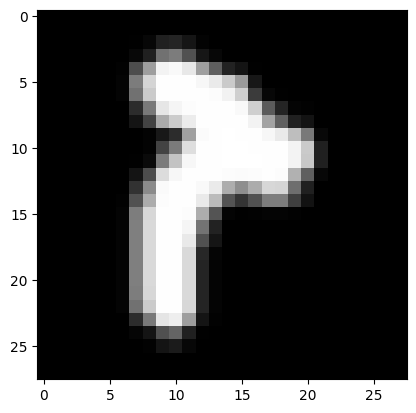

Label: 45


In [2]:
## Sanity check for the first image and also the first label

import matplotlib.pyplot as plt

print(x_train[0].shape, x_train[0].dtype)
print(x_train[0])
plt.imshow(x_train[0], cmap='gray')
plt.show()
print("Label:", y_train[0])

### 2. Data Pre-Processing

As you can see above, the  is in the array form with a pixel values from 0-255, which shows us the grayscale for a particular picture. Since the deep learning models work better when normalized to 0-1, so I will normalize all of the pixel values for both the `x_train` and `x_test`

In [3]:
# Normalize images to range [0,1]

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [4]:
## Reshape images to (28,28,1) for CNN

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (112800, 28, 28, 1)
x_test shape: (18800, 28, 28, 1)


In [5]:
import tensorflow as tf
import numpy as np

# Convert NumPy arrays to TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
test_ds = tf.data.Dataset.from_tensor_slices(x_test)

# Define the function to fix orientation
def fix_orientation(image):
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    return image

train_ds = train_ds.map(fix_orientation, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(fix_orientation, num_parallel_calls=tf.data.AUTOTUNE)

# Convert back to NumPy (if needed)
x_train_fixed = np.array(list(train_ds.as_numpy_iterator()))
x_test_fixed = np.array(list(test_ds.as_numpy_iterator()))

print("✅ Image transformation completed successfully!")


✅ Image transformation completed successfully!


In [6]:
from tensorflow.keras.utils import to_categorical

num_classes = 47 # 47 classes in the EMNIST Balanced dataset

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

### 3. Build the Model

Here, since the dataset is image and our main goal is image classification, I will make the CNN **(Convolutional Neural Network)** model to classify those handwritten letters and digits.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN Model
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(47, activation='softmax')  # 47 classes for EMNIST Balanced dataset
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906,031 (3.46 MB)

 Trainable params: 906,031 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(x_train_fixed, y_train, validation_data=(x_test_fixed, y_test), epochs=15, batch_size=32)

Epoch 1/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 193s 52ms/step - accuracy: 0.6994 - loss: 1.0117 - val_accuracy: 0.8576 - val_loss: 0.4134
Epoch 2/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 183s 52ms/step - accuracy: 0.8585 - loss: 0.3996 - val_accuracy: 0.8704 - val_loss: 0.3673
Epoch 3/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 175s 50ms/step - accuracy: 0.8798 - loss: 0.3271 - val_accuracy: 0.8755 - val_loss: 0.3489
Epoch 4/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 158s 45ms/step - accuracy: 0.8916 - loss: 0.2856 - val_accuracy: 0.8804 - val_loss: 0.3467
Epoch 5/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 151s 43ms/step - accuracy: 0.9011 - loss: 0.2572 - val_accuracy: 0.8869 - val_loss: 0.3435
Epoch 6/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 128s 36ms/step - accuracy: 0.9101 - loss: 0.2266 - val_accuracy: 0.8832 - val_loss: 0.3517
Epoch 7/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 163s 46ms/step - accuracy: 0.9140 - loss: 0.2135 - val_accuracy: 0.8811 - val_loss: 0.3708
Epoch 8/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 137s 39ms/step - accuracy: 

### 4. Testing the Results

In [9]:
test_loss, test_acc = model.evaluate(x_test_fixed, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8779 - loss: 0.5502
Test Accuracy: 0.8774


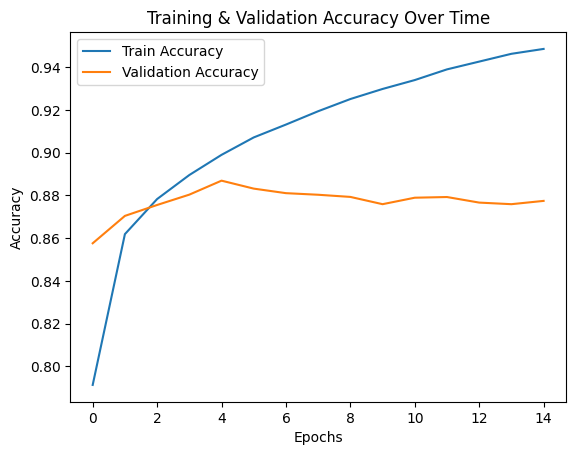

In [10]:
## Plot Accuracy

import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Time')
plt.show()


588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


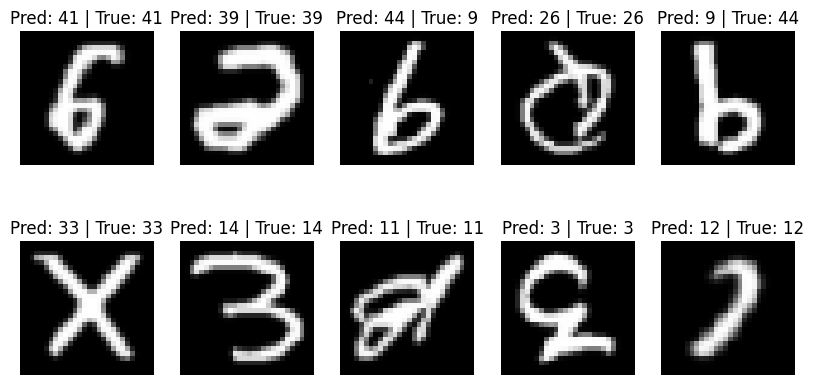

In [11]:
import numpy as np

# Make predictions
predictions = model.predict(x_test_fixed)

# Plot some test images with predictions
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test_fixed[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {np.argmax(predictions[i])} | True: {np.argmax(y_test[i])}")
    plt.axis("off")
plt.show()

588/588 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


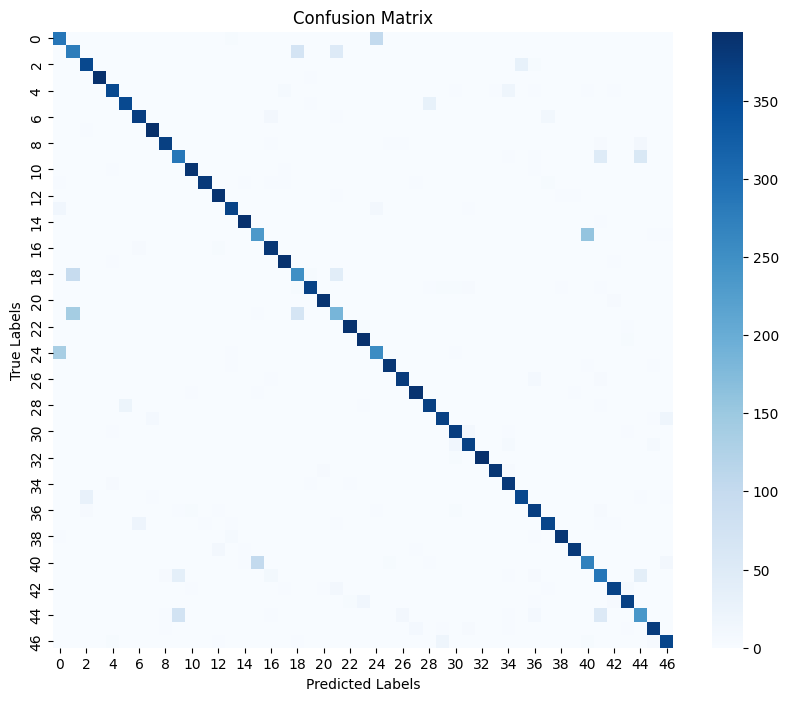

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true & predicted labels
y_pred = np.argmax(model.predict(x_test_fixed), axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get true and predicted labels
y_pred = np.argmax(model.predict(x_test_fixed), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and f1 score for each class (macro averaging)
precision = precision_score(y_true, y_pred, average='macro', labels=np.unique(y_true))
recall = recall_score(y_true, y_pred, average='macro', labels=np.unique(y_true))
f1 = f1_score(y_true, y_pred, average='macro', labels=np.unique(y_true))

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (macro): {precision:.4f}')
print(f'Recall (macro): {recall:.4f}')
print(f'F1 Score (macro): {f1:.4f}')


588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Accuracy: 0.8774
Precision (macro): 0.8787
Recall (macro): 0.8774
F1 Score (macro): 0.8773


Then, that will be the end of the notebook, and I have made a model that can be used to classify a handwritten text or digits using CNN Models. We also got a quite high accuracy percentage around 87%, which is quite impressive since the amount of testing set is reaching 18800 (big number isn't it?). And this wraps up the notebook

Observations and Notes:

1. Adding number of epochs is not always giving a significant boost on the accuracy
2. Adding number of layers may increase the accuracy, but I need to add it more carefully and with more meticulous, so it will give a nicer result.
3. EMNICS is harder to process than the usual MNICS, since it is the mictures of digits and letters, and doing the rotation and reflection helps the machine to learn better.